# MSE403 Lab 6: Classification
This lab is to perform classification on three ternary systems that make up 3/4 of a Co-Zr-Cr-Ti quaternary metallic glass forming alloy. The goal is to generate predictions of
the glass forming ability of this quaternary system using only the ternaries as training data.

#### Reference and Github copilot usage
The entire coding section of this lab report is written under the help of Github Copilot. The usage of large language model like ChatGPT will be marked.
A large section of code in this report is modified from MSE403 Practice 7. Any external reference will be marked.

## 1. Open the data, perform basic data preparation/cleaning

import the necessary packages, and read the data of each ternary system, concatenating them into a quaternary dataframe.

In [1]:
import scipy.io
import numpy.matlib as nm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy

In [ ]:
df_crtizr = pd.read_excel('Metallic Glass Data.xlsx', sheet_name='CrTiZr')   #read the data of each ternary system
df_crtizr = df_crtizr.dropna(axis=1)
df_crtizr['Co'] = 0   #For Co which does not exist in this ternary system, its composition would be set to 0

df_crcozr = pd.read_excel('Metallic Glass Data.xlsx', sheet_name='CrCoZr')
df_crcozr = df_crcozr.dropna(axis=1)
df_crcozr['Ti'] = 0

df_cotizr = pd.read_excel('Metallic Glass Data.xlsx', sheet_name='CoTiZr')
df_cotizr = df_cotizr.dropna(axis=1)
df_cotizr['Cr'] = 0

df_qua = pd.concat([df_crtizr, df_crcozr, df_cotizr], ignore_index=True)
df_qua = df_qua[['Cr', 'Co', 'Ti', 'Zr', 'Glass (TRUE/FALSE)']]

#drop the column 'Glass (True/False)'
df_comp = df_qua.drop(['Glass (TRUE/FALSE)'], axis=1)

Some custom functions are written into a separate python file and imported to shorten the length of this report. The .py file with all the custom functions will also be uploaded to the Github repository.

In [2]:
import lab6_my_func as mf

Featurize the data using Miedema and WenAlloys featurizers from matminer package.

## 2. Demonstrate your ability to perform classification using matminer features to build a model that classifies the glass forming ability for the entire quaternary phase diagram.

In [ ]:
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import Miedema

formula = 'Cr'+df_qua['Cr'].astype(str)+'Ti'+df_qua['Ti'].astype(str)+'Co'+df_qua['Co'].astype(str)+'Zr'+df_qua['Zr'].astype(str)
df_mat = pd.DataFrame({'Formula':formula, 'Glass (TRUE/FALSE)':df_qua['Glass (TRUE/FALSE)']})

#convert the formula from a string into chemical composition
df_mat = StrToComposition().featurize_dataframe(df_mat, "Formula")   #Featurization
df_mat = Miedema().featurize_dataframe(df_mat, col_id="composition")   #Featurization using Miedema featurizer

In [ ]:
from matminer.featurizers.composition import WenAlloys

df_mat_1 = WenAlloys().featurize_dataframe(df_mat, col_id="composition")   #Featurization using WenAlloys featurizer

In [ ]:
df_mat = pd.concat([df_mat_1, df_comp], axis=1)   #add the composition to the dataframe

df_mat.to_csv('matminer_data.csv', index=False)   #This is to save the featurized data so that MatMiner does not have to be runend every time

In [3]:
df_mat = pd.read_csv('matminer_data.csv')

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [5]:
#The group_based_on_ternary function add a columns to the dataframe with labels that indicate which ternary system the data belongs to
df_mat_group = mf.group_based_on_ternary(df_mat)            #Group the data based on ternary system
ternary_group = df_mat_group['group']    #Get the unique group number

#The drop_correlated_features function drops the features that are highly correlated, the threshold is a hyperparameter
#It returns a list that includes the names of the features that are supposed to be dropped
to_drop = mf.drop_correlated_features(df_mat_group, 0.9)   #Drop the features that are highly correlated, the threshold is set to be 0.9
mat_Yang_delta = df_mat_group['Yang delta']   #save the Yang delta and omega values for the entire quaternary dataset
mat_Yang_omega = df_mat_group['Yang omega']
df_mat_group = df_mat_group.drop(to_drop, axis=1, errors='ignore')

mat_y = df_mat_group['Glass (TRUE/FALSE)']
#The non-numerical features are dropped
mat_X = df_mat_group.drop(['Formula', 'Glass (TRUE/FALSE)', 'group','composition','Weight Fraction','Atomic Fraction',], axis=1, errors='ignore')



PCA Analysis is applied for dimensional reduction and visualization

In [6]:
sc = StandardScaler()   #Standardize the data
sc.fit(mat_X)
mat_X_std = sc.transform(mat_X)

pca = PCA()   #Apply PCA to the data
pca.fit(mat_X_std)
loading_vectors = pca.components_
explained_variance = pca.explained_variance_
pos = pca.transform(mat_X_std)

Create a plot to show the explained variance of each principal component

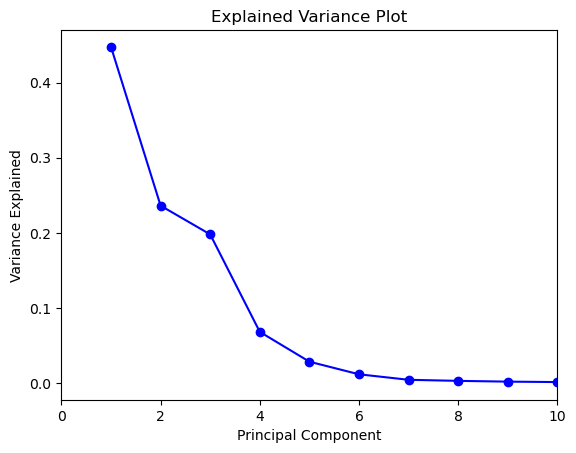

In [7]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', color='blue')
plt.title('Explained Variance Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xlim(0,10)
plt.show()

Visualize the data in PCA space

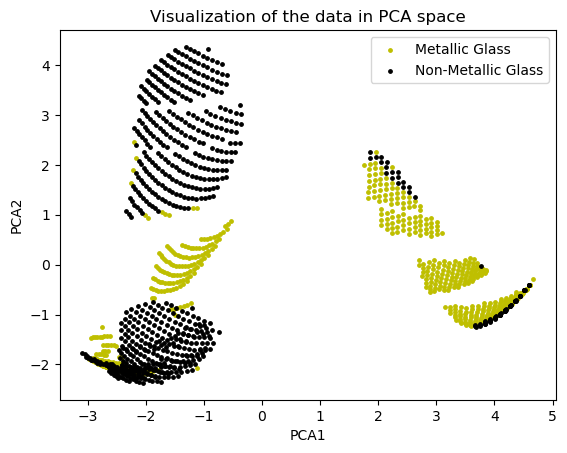

In [8]:
plt.scatter(pos[:,0][mat_y==1],pos[:,1][mat_y==1],c = 'y',label = 'Metallic Glass',s=6)   #The metallic glass is shown in yellow points
plt.scatter(pos[:,0][mat_y==0],pos[:,1][mat_y==0],c = 'black',label = 'Non-Metallic Glass',s=6)   #The non-metallic glass is shown in black points

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Visualization of the data in PCA space')
plt.legend()

In [9]:
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
#import confusion matrix display
from sklearn.metrics import ConfusionMatrixDisplay
#import roc curve display
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


TRAIN: 882 TEST: 441
TRAIN: 882 TEST: 441
TRAIN: 882 TEST: 441


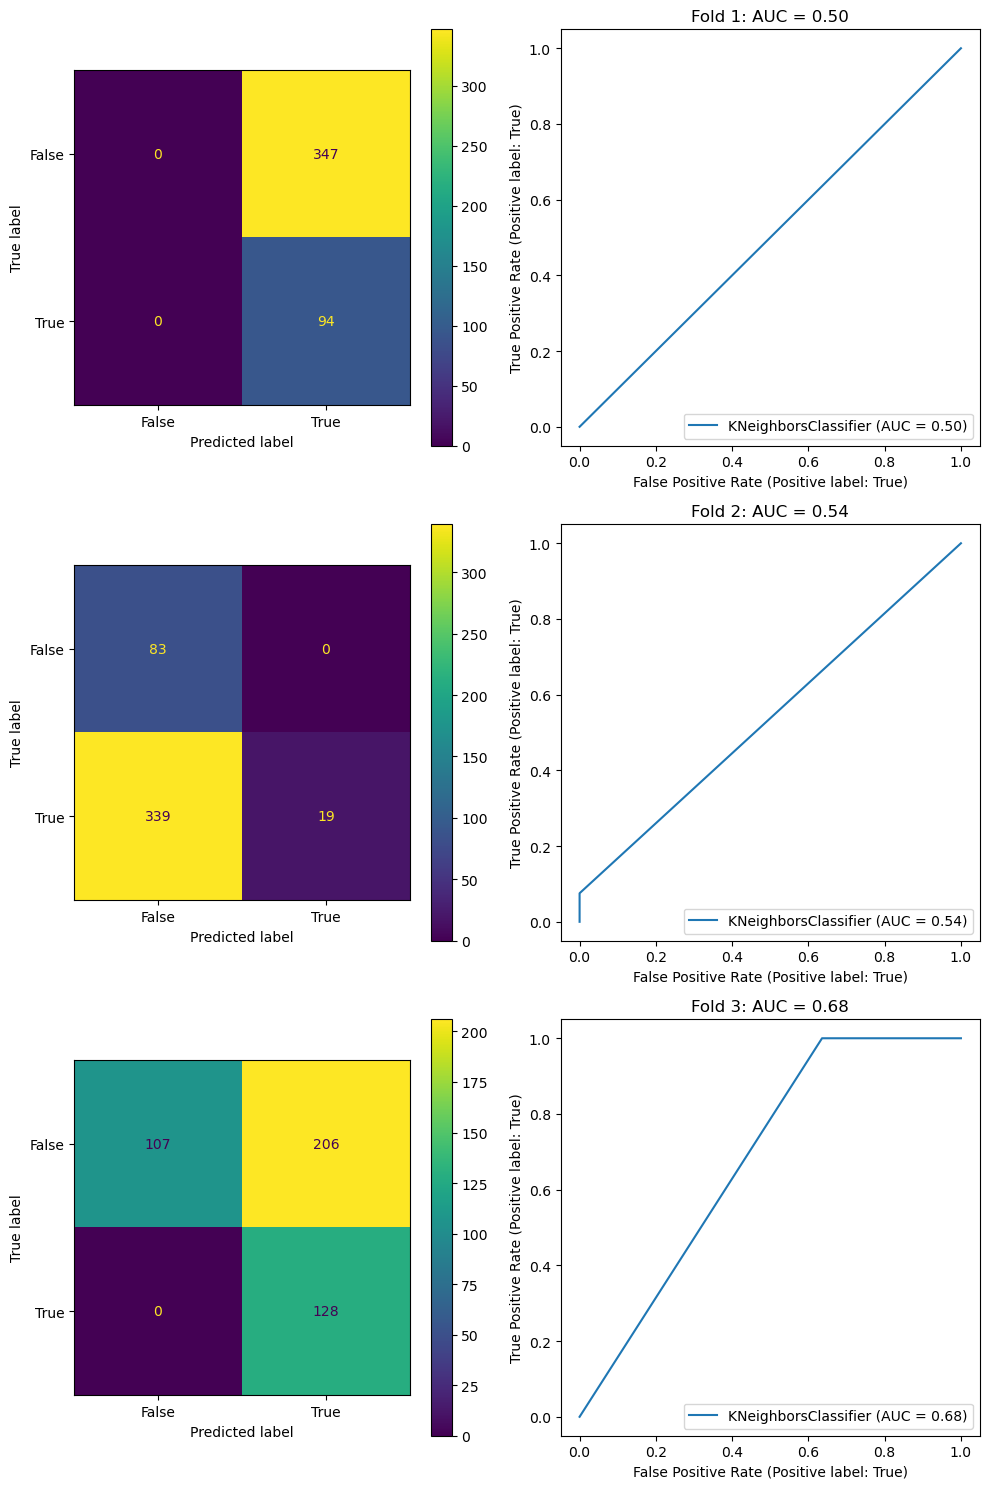

In [10]:
# LOGO(mat_X,mat_y,ternary_group) is a function that take the data and the group number as input, doing LOGO cv split, and returns a list of test, train datasets and their index
mat_loco_list = mf.LOGO(mat_X, mat_y, ternary_group)
#KNN_cv(cv_list, n_split=5, plot=True) is a function that take the list of test, train sets and the indexes (generated by the previous function) and perform KNN classification and show the confusion matrix and ROC curve
mf.KNN_cv(mat_loco_list)

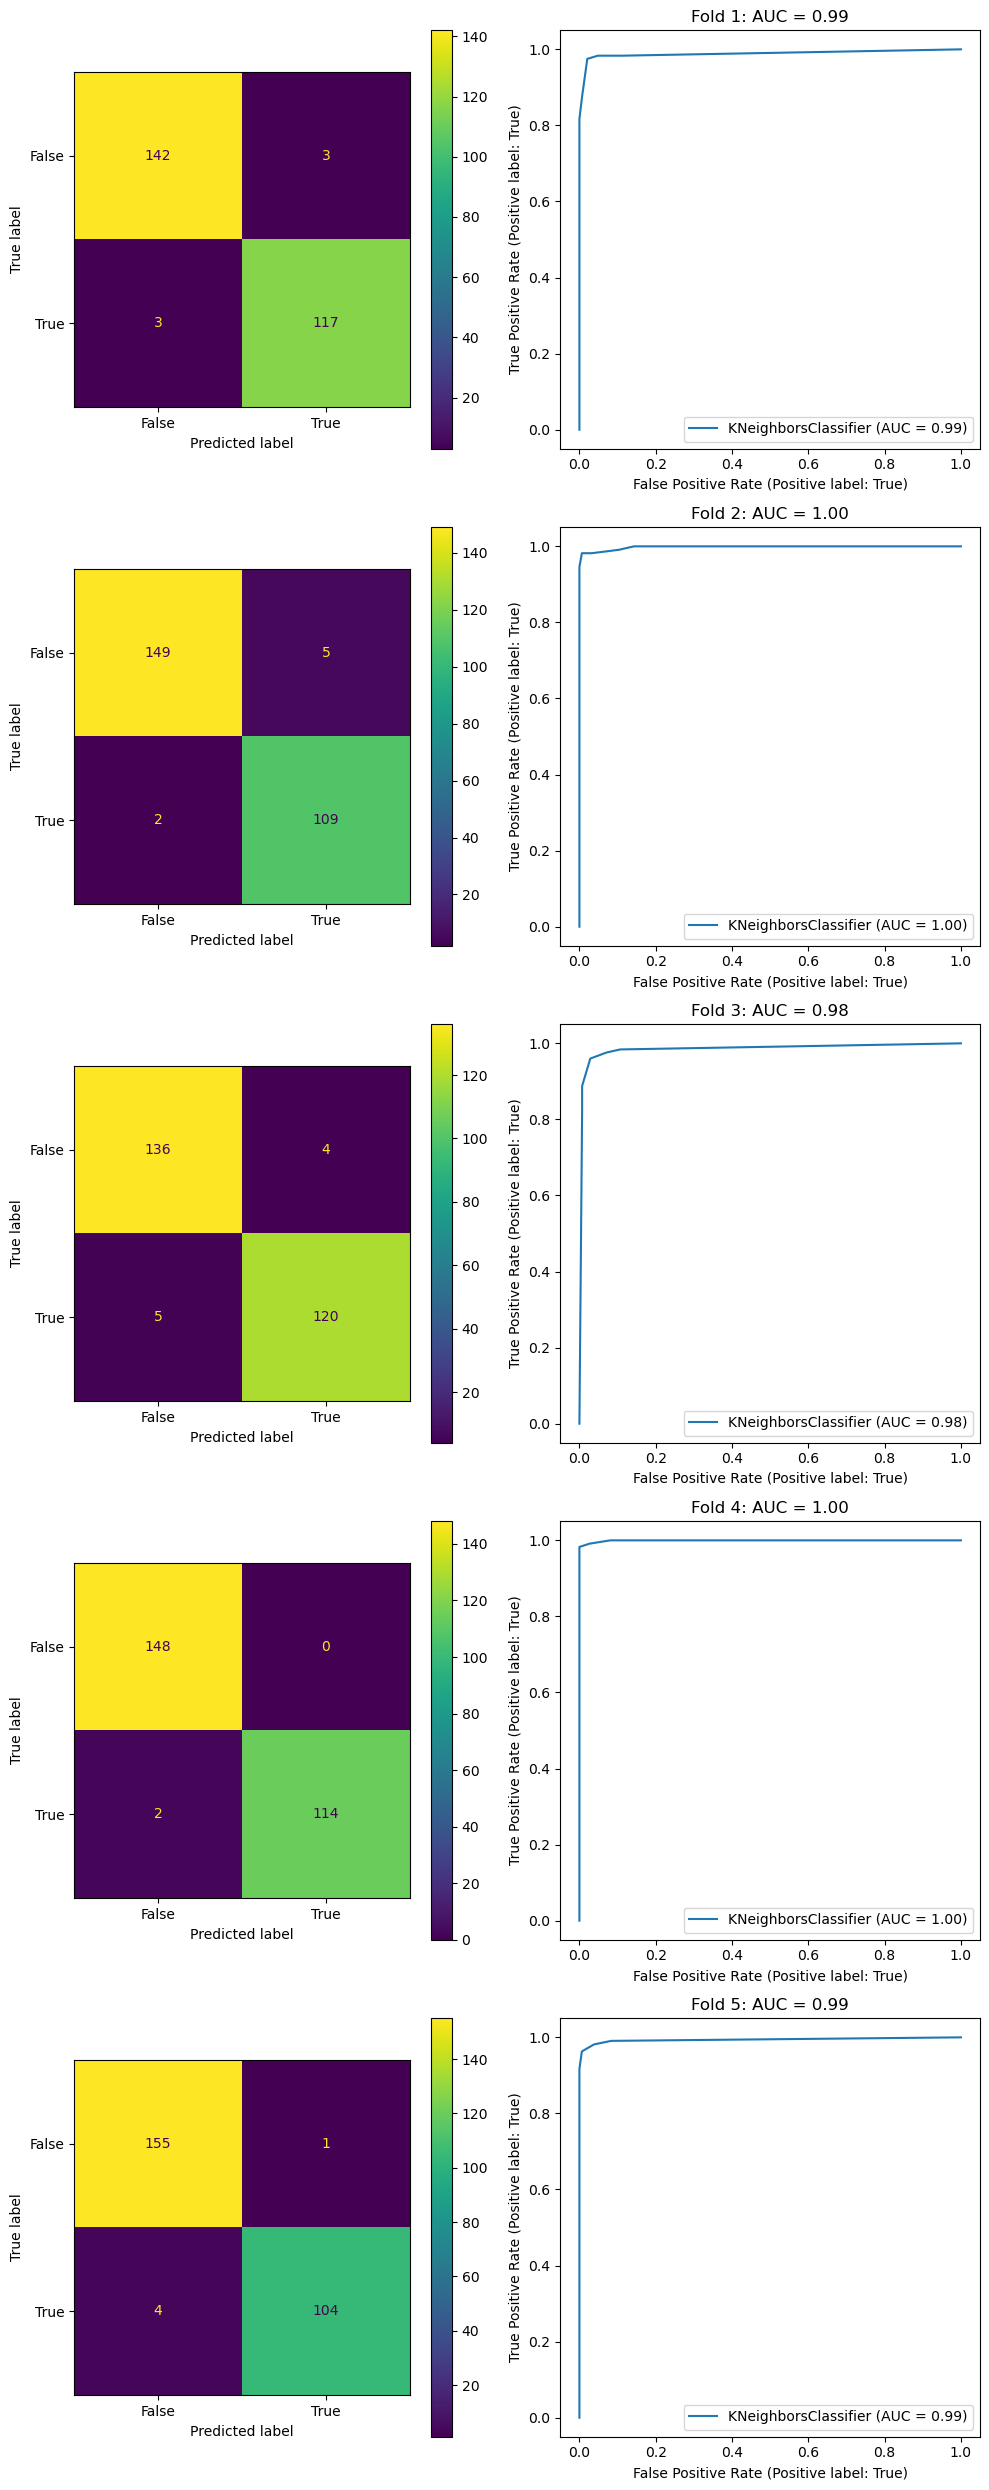

In [11]:
#random_cv is a function that take the data and the number of folds as input, doing random cv test, train split, and returns a list of test, train datasets and their index
mat_random_list = mf.random_cv(mat_X, mat_y, 5)
mf.KNN_cv(mat_random_list, 5)

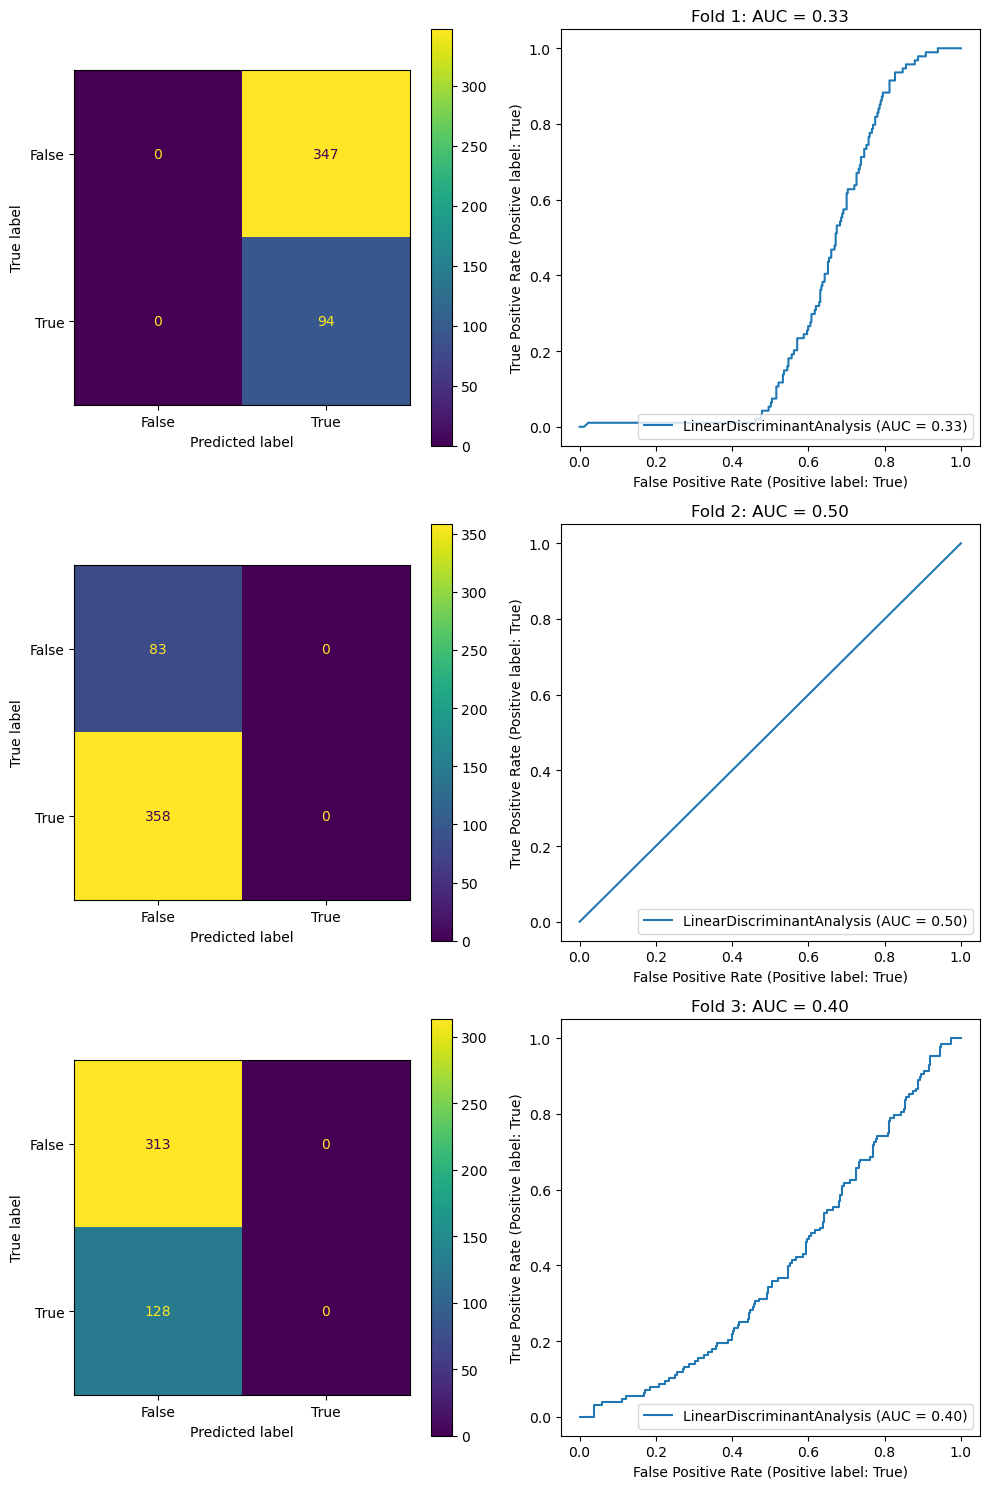

In [12]:
#LDA_cv is a funciton that take the cv list as input and perform LDA classification and show the confusion matrix and ROC curve
mf.LDA_cv(mat_loco_list)   #Performing LDA classification on the LOCO cv split

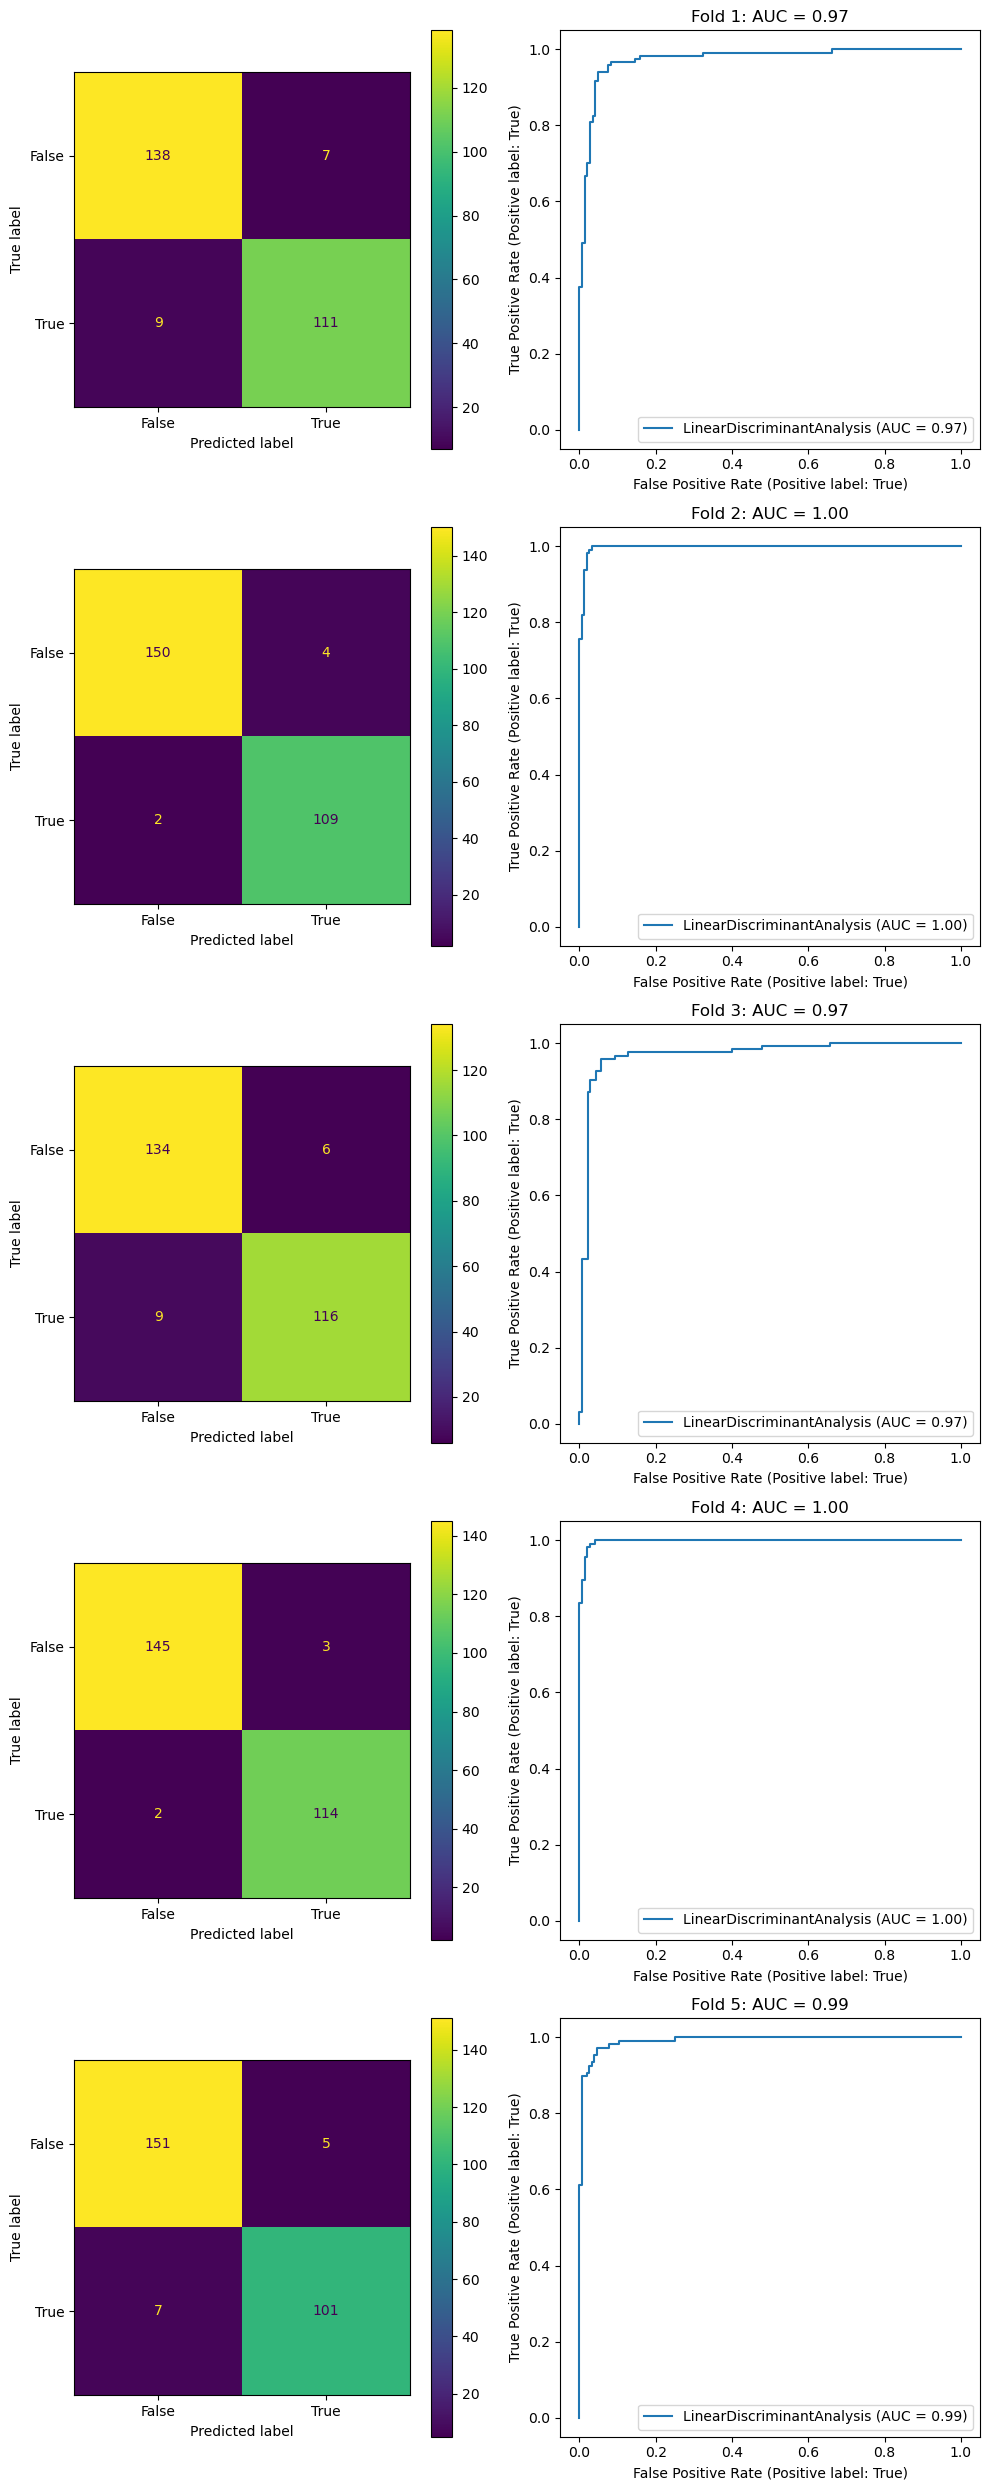

In [13]:
mf.LDA_cv(mat_random_list, 5)   #Performing LDA classification on the random cv split

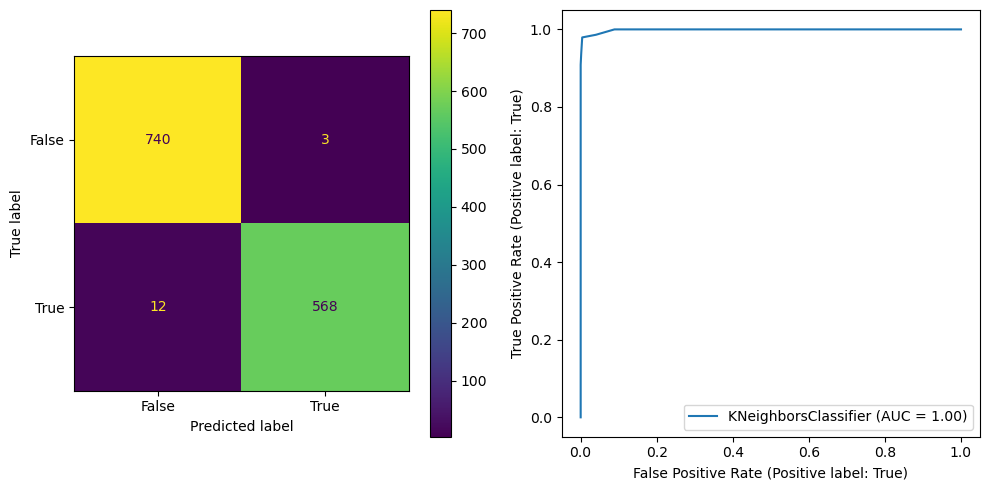

In [14]:
#The KNN_entire_model function takes the entire dataset and the number of neighbors as input and train a KNN model on the entire dataset
mf.KNN_entire_model(mat_X, mat_y, 5)

From the confusion matrix and ROC curve, we can see that in the LOGO CV, the predictive power is extremely low. This is because the model is trained on two ternary systems, and then used to predict the third ternary system. The model is not able to generalize to the third ternary system. On the other hand, the predictive power of random cv using both models (KNN and LDA) are extremely high, reaching around 99% of accuracy.

## 3. Predict the Glass forming ability for the entire Co-Zr-Cr-Ti quaternary phase diagram (use 5 at.% increments) using the full data models

The following code is used to generate the entire quaternary dataset

In [ ]:
dict_entire_qua = {'Cr':[], 'Co':[], 'Ti':[], 'Zr':[]}  #copilot

for cr in np.arange(0,1.05,0.05):   #Creat the quaternary composition dataframe with 5 at.% increments
    for ti in np.arange(0,1.05,0.05):
        for co in np.arange(0,1.05,0.05):
            for zr in np.arange(0,1.05,0.05):
                if cr+ti+co+zr == 1.0:
                    dict_entire_qua['Cr'].append(round(cr,3))
                    dict_entire_qua['Ti'].append(round(ti,3))
                    dict_entire_qua['Co'].append(round(co,3))
                    dict_entire_qua['Zr'].append(round(zr,3))
df_entire_qua = pd.DataFrame(dict_entire_qua)

Featurize the entire quaternary dataset using the same featurizers

In [ ]:
formula = 'Cr'+df_entire_qua['Cr'].astype(str)+'Ti'+df_entire_qua['Ti'].astype(str)+'Co'+df_entire_qua['Co'].astype(str)+'Zr'+df_entire_qua['Zr'].astype(str)
df_entire_mat = pd.DataFrame({'Formula':formula})

#convert the formula from a string into chemical composition
df_entire_mat = StrToComposition().featurize_dataframe(df_entire_mat, "Formula")
df_entire_mat = Miedema().featurize_dataframe(df_entire_mat, col_id="composition")
df_entire_mat = WenAlloys().featurize_dataframe(df_entire_mat, col_id="composition")

In [ ]:
df_entire = pd.concat([df_entire_mat, df_entire_qua], axis=1)   #combine with the composition features

df_entire.to_csv('quaternary data.csv', index=False)   #Save the featurized data

In [16]:
df_entire = pd.read_csv('quaternary data.csv')
df_entire = df_entire.drop(['Formula', 'Glass (TRUE/FALSE)' ,'composition','Weight Fraction','Atomic Fraction'], axis=1, errors='ignore')   #Drop non-numerical features

entire_Yang_delta = df_entire['Yang delta']   #save the Yang delta and omega values for the entire quaternary dataset
entire_Yang_omega = df_entire['Yang omega']

df_entire = df_entire.drop(to_drop, axis=1, errors='ignore')

Compared the predicted glass forming ability of the entire quaternary dataset using the KNN and LDA models on Yang plots

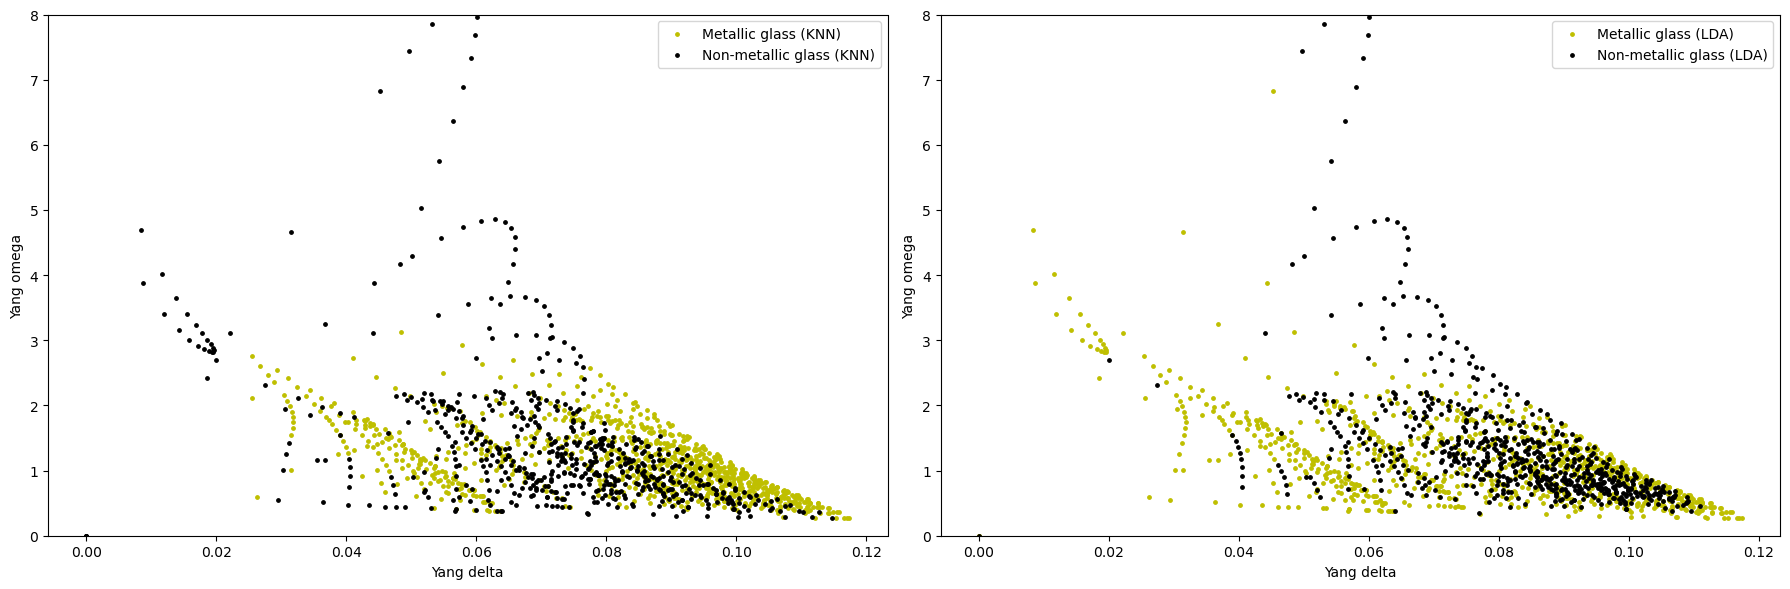

In [17]:
KNN = KNeighborsClassifier(n_neighbors=5)
LDA = LinearDiscriminantAnalysis()

sc = StandardScaler()   #Standardize the data
sc.fit(mat_X)
mat_X = sc.transform(mat_X)
df_entire = sc.transform(df_entire)

#KNN Model:
KNN.fit(mat_X, mat_y)   #Train the KNN model
y_pred = KNN.predict(df_entire)
LDA.fit(mat_X, mat_y)   #Train the LDA model
y_pred_LDA = LDA.predict(df_entire)

#make the scatter plot bigger
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)

plt.scatter(entire_Yang_delta[y_pred==1], entire_Yang_omega[y_pred==1], c='y', label='Metallic glass (KNN)', s=6)   #Metallic Glass is marked as yellow
plt.scatter(entire_Yang_delta[y_pred==0], entire_Yang_omega[y_pred==0], c='black', label='Non-metallic glass (KNN)', s=6)   #Non-metallic glass is marked as black
plt.ylim(0,8)
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.legend()


#LDA model:
plt.subplot(1,2,2)
plt.scatter(entire_Yang_delta[y_pred_LDA==1], entire_Yang_omega[y_pred_LDA==1], c='y', label='Metallic glass (LDA)', s=6)
plt.scatter(entire_Yang_delta[y_pred_LDA==0], entire_Yang_omega[y_pred_LDA==0], c='black', label='Non-metallic glass (LDA)', s=6)

#plt.scatter(entire_Yang_delta, entire_Yang_omega, c=y_pred,cmap='viridis', s=6)
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.legend()
#set the y limit to 8 to remove the outliers
plt.ylim(0,8)

plt.tight_layout()

#give the figure a tight layout


Visualize the entire quaternary dataset in PCA space using the KNN and LDA models

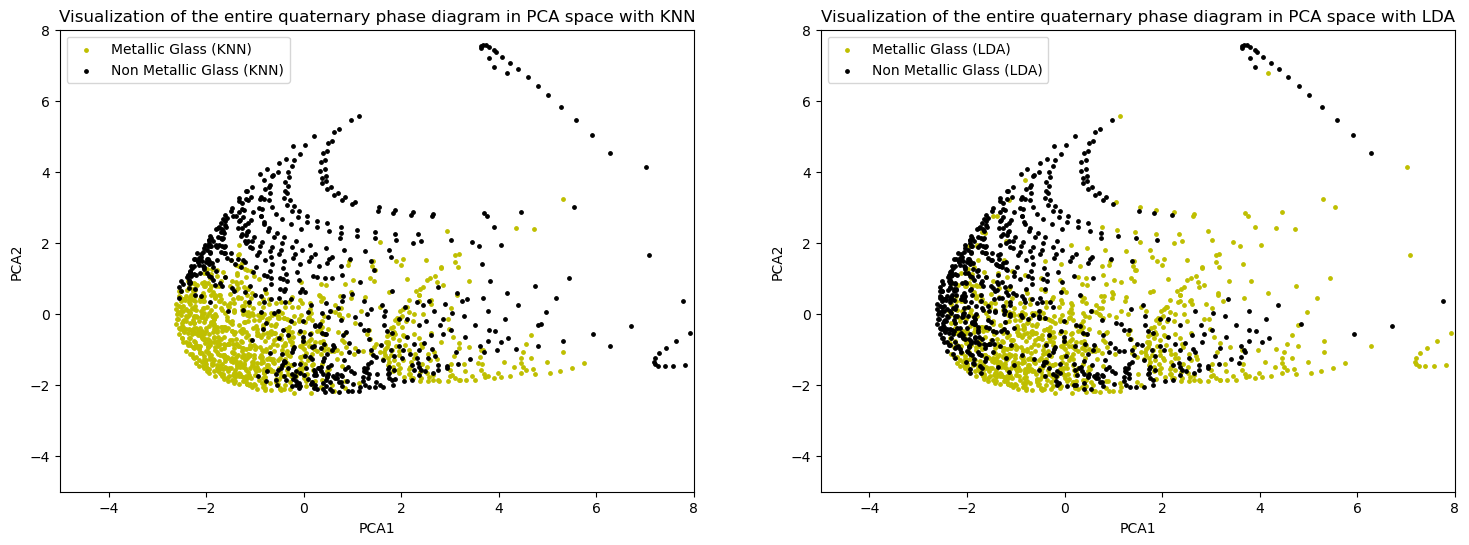

In [18]:
sc = StandardScaler()   #Standardize the data
sc.fit(df_entire)
df_entire_std = sc.transform(df_entire)

pca.fit(df_entire_std)   #Fit the PCA model
pos_entire = pca.transform(df_entire_std)

plt.figure(figsize=(18,6))

#KNN:
plt.subplot(1,2,1)
plt.scatter(pos_entire[:,0][y_pred==1], pos_entire[:,1][y_pred==1],c='y', label='Metallic Glass (KNN)',s=6)
plt.scatter(pos_entire[:,0][y_pred==0], pos_entire[:,1][y_pred==0],c='black',label = 'Non Metallic Glass (KNN)',s=6)
plt.xlim(-5,8)
plt.ylim(-5,8)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Visualization of the entire quaternary phase diagram in PCA space with KNN')
plt.legend()

#LDA:
plt.subplot(1,2,2)
plt.scatter(pos_entire[:,0][y_pred_LDA==1], pos_entire[:,1][y_pred_LDA==1],c='y', label='Metallic Glass (LDA)',s=6)
plt.scatter(pos_entire[:,0][y_pred_LDA==0], pos_entire[:,1][y_pred_LDA==0],c='black',label = 'Non Metallic Glass (LDA)',s=6)
plt.xlim(-5,8)
plt.ylim(-5,8)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Visualization of the entire quaternary phase diagram in PCA space with LDA')
plt.legend()


Plot the probability of each point to be a metallic glass using different classifiers

In [19]:
def plot_probability(model):

    model.fit(mat_X, mat_y)
    proba = model.predict_proba(df_entire)[:,0]*100

    cmap=plt.cm.viridis_r
    norm = plt.Normalize(0, proba.max())
    fig, ax = plt.subplots()

    grid = plt.GridSpec(10, 10, wspace=2, hspace=1)
    ax = plt.subplot(grid[:,:9])

    plt.scatter(entire_Yang_delta, entire_Yang_omega, c = cmap(1-norm(proba)), s=6)
    plt.xlabel('Yang delta')
    plt.ylabel('Yang omega')
    plt.ylim(0,8)

    #I want to make my plot wider  -- copilot
    fig.set_size_inches(12, 6)
    ax = plt.subplot(grid[1:-1,9:])
    cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
    cb1.set_label(label='MG Probability', size=18)

C:\Users\28452\AppData\Local\Temp\ipykernel_15180\1337038138.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(grid[:,:9])


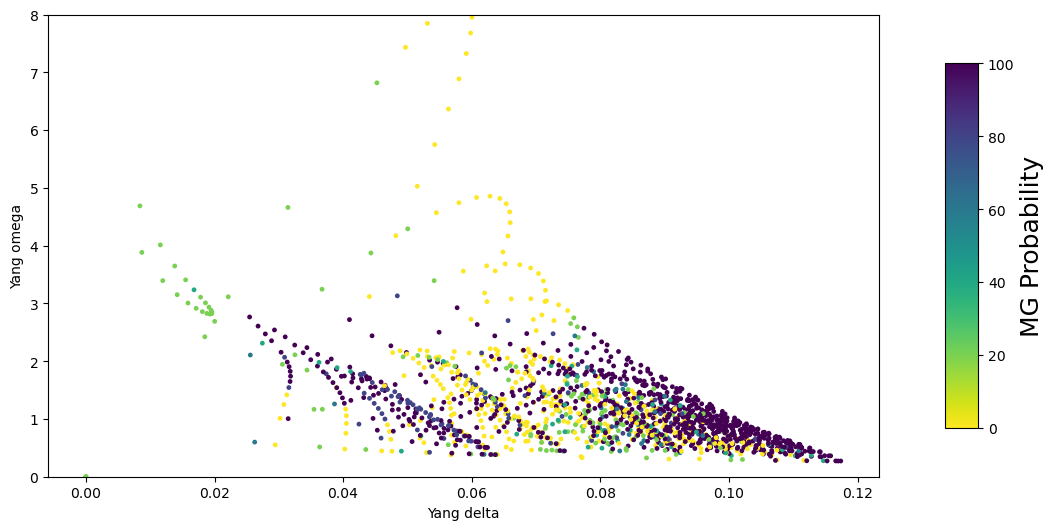

In [20]:
plot_probability(KNeighborsClassifier(n_neighbors=5))

C:\Users\28452\AppData\Local\Temp\ipykernel_15180\1337038138.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(grid[:,:9])


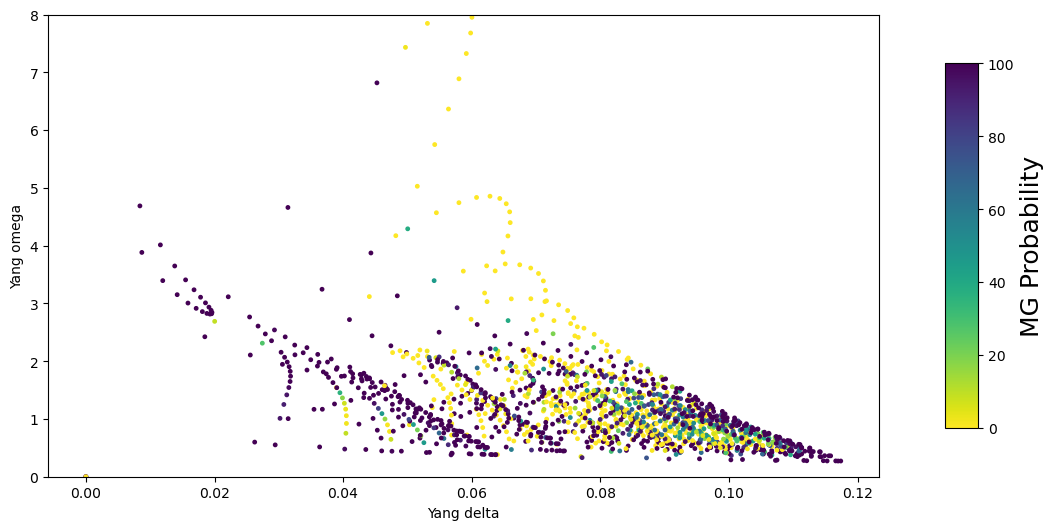

In [21]:
plot_probability(LinearDiscriminantAnalysis())

C:\Users\28452\AppData\Local\Temp\ipykernel_15180\1337038138.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(grid[:,:9])


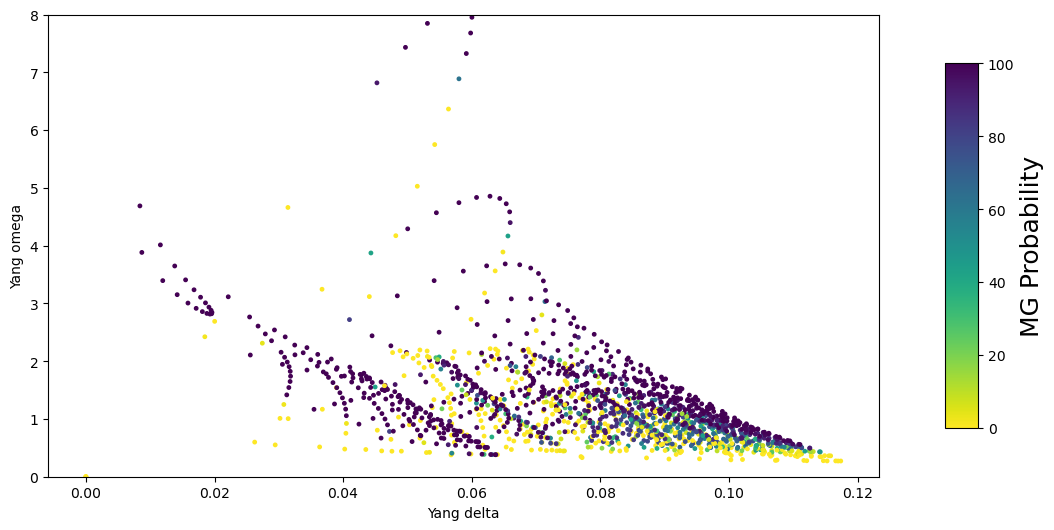

In [22]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
plot_probability(GNB)

Compare the predicted result with ternary phase diagram using different classifiers

In [23]:
def compare_predicted_result_with_ternary(model):

    model.fit(mat_X, mat_y)
    y_pred = model.predict(df_entire)

    #Make the plot bigger
    plt.figure(figsize=(18,6))

    plt.subplot(1,2,1)

    plt.scatter(entire_Yang_delta[y_pred==1], entire_Yang_omega[y_pred==1], c='y', label='Metallic glass', s=6)
    plt.scatter(entire_Yang_delta[y_pred==0], entire_Yang_omega[y_pred==0], c='black', label='Non-metallic glass', s=6)
    #set the y limit to 8 to remove the outliers

    plt.ylim(0,5)
    plt.xlim(0.04,0.12)
    plt.xlabel('Yang delta')
    plt.ylabel('Yang omega')
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(mat_Yang_delta[mat_y==1], mat_Yang_omega[mat_y==1], c='y', label='Metallic glass', s=6)
    plt.scatter(mat_Yang_delta[mat_y==0], mat_Yang_omega[mat_y==0], c='black', label='Non-metallic glass', s=6)

    plt.xlabel('Yang delta')
    plt.ylabel('Yang omega')
    plt.ylim(0,5)
    plt.xlim(0.04,0.12)
    plt.legend()

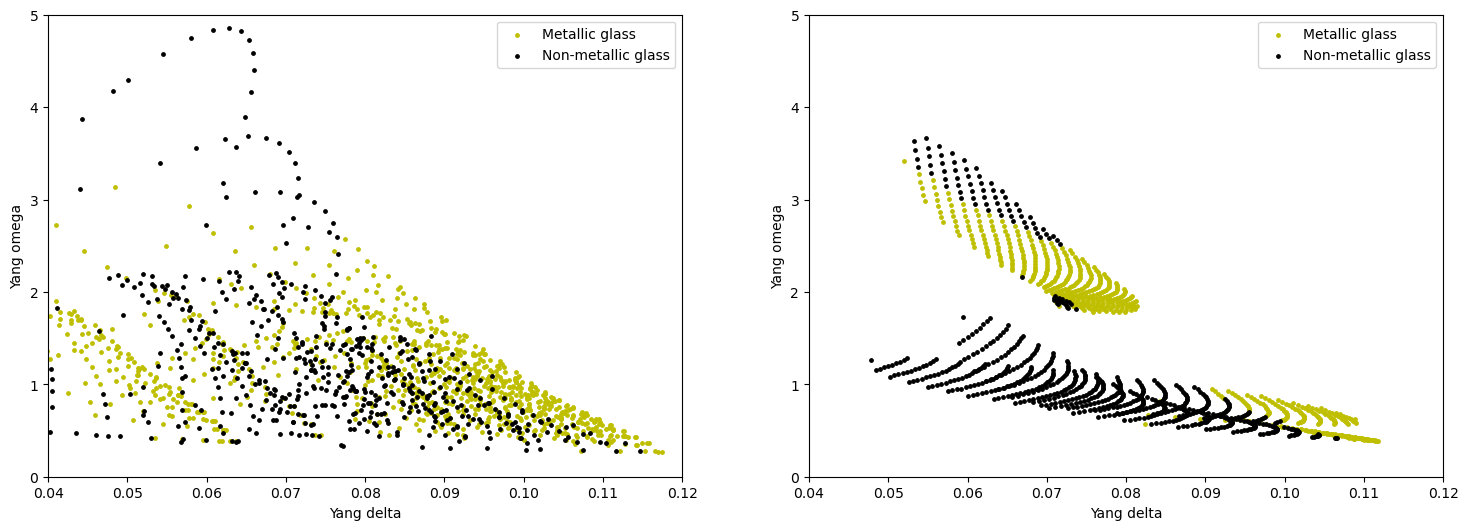

In [24]:
compare_predicted_result_with_ternary(model=KNeighborsClassifier(5))

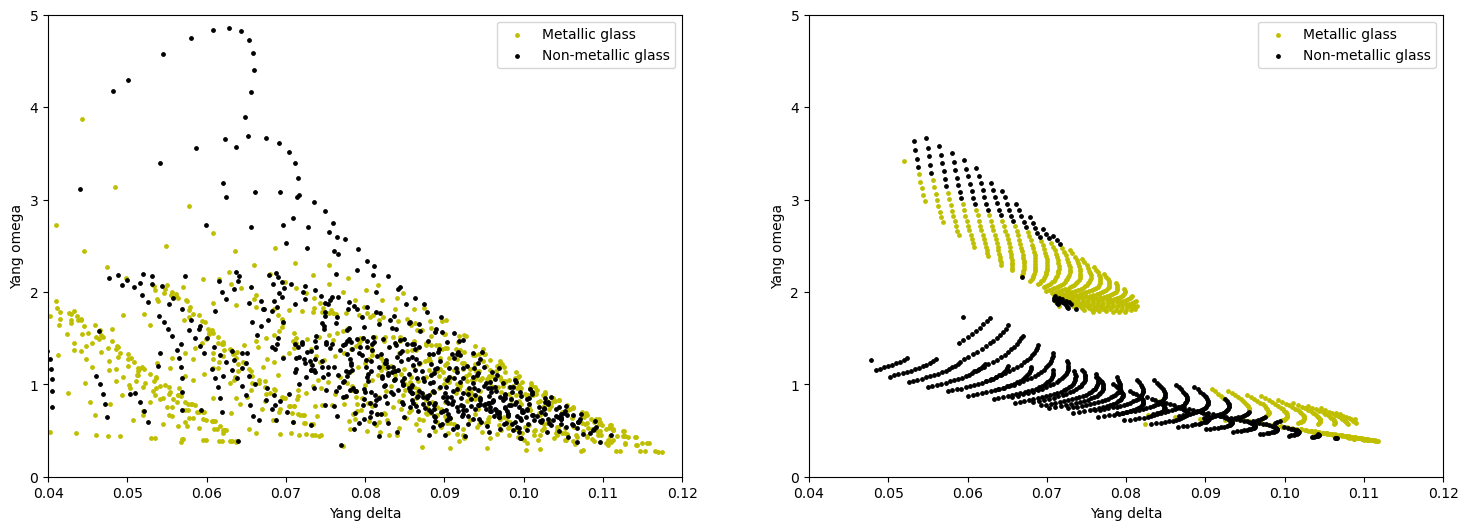

In [25]:
compare_predicted_result_with_ternary(model=LinearDiscriminantAnalysis())

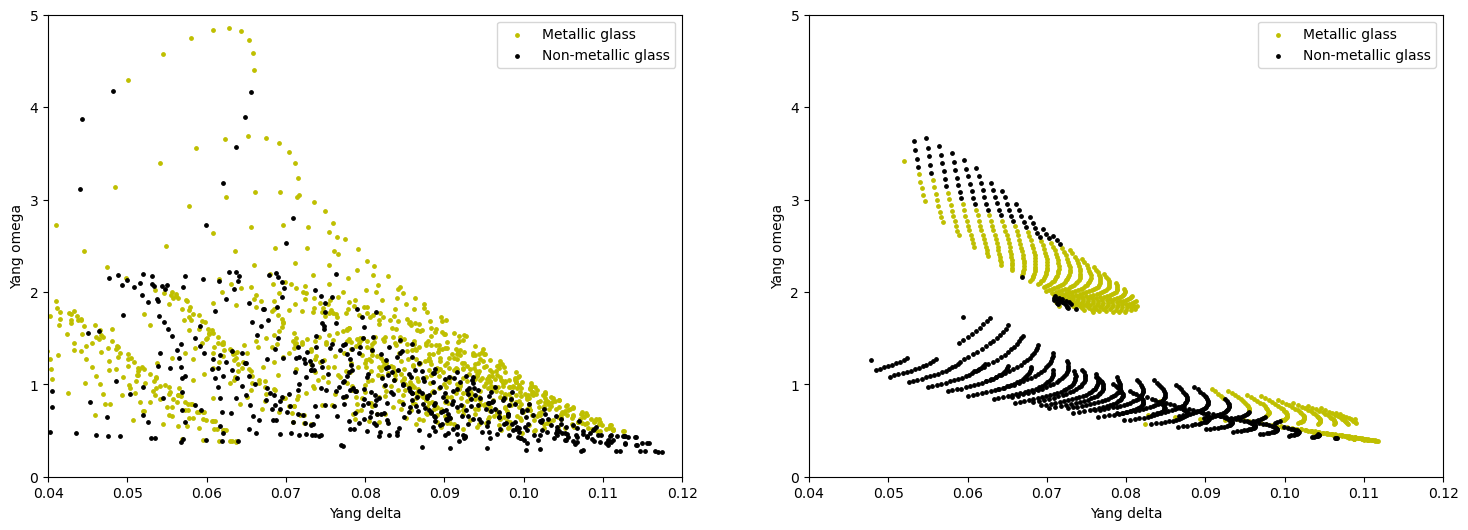

In [26]:
compare_predicted_result_with_ternary(GNB)

## Summary
- In this lab, classification models are trained based on ternary systems data. Validation statistical techniques are applied, including random cross validation and Leave-one-out cross validaiton. The performance of the models are compared using the confusion matrix and ROC curve.
- In LOGO CV, the model performs poorly due to poor generalizability of the model. In random CV, the model performs extremely well with an average AUC score of 0.98 on both KNN and LDA models. The reason why KNN model has a high AUC score might due to its look-up-table nature, while the reason for LDA model is yet unknown.
- PCA is used for dimensional reduction and visualizaiton of the multi-dimensional data. However it is not used to train the classification models. The classification models are trained with the original features.
- Three different classificaiton models are trained with the entire ternary data, and used to predict the quaternary system. The predicitons from the three models are different, however it is difficult to tell which one is better.
- The predictions of all three models have some deviations from the ground truth given by the ternary system data.